This notebook contains the codes necessary to produce the figures (apart from the last one) of the article “Line-of-sight effects in strong gravitational lensing” [https://arxiv.org/abs/2104.08883] by Pierre Fleury, Julien Larena, and Jean-Philippe Uzan.

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import cmath as c
from scipy.special import jv as BesselJ

# Use TeX
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 15})

In [10]:
path = '/Users/pierrefleury/Dropbox/Project - LOS in strong lensing/article - Line-of-sight effects in strong gravitational lensing/figures/'

# Parameterised LOS effects

## Definitions
All angles are expressed in arcsec ("). This choice is arbitrary.

In [2]:
# Source profiles

Gaussian = lambda beta, beta0, sigma: np.exp(-np.abs(beta-beta0)**2/(2*sigma**2))


# Dominant-lens models

def alphaSIS(theta, theta0=1):
    """Displacement angle for SIS. Arguments:
- theta: complex image position
- theta0: Einstein radius
"""
    
    alpha = theta0*theta/abs(theta)
    
    return alpha;


def alphaSIE(theta, theta0=1, f=0.7, phi0=0):
    """Displacement angle for SIE. Arguments:
- theta: complex image position
- theta0: Einstein radius
- f=b/a: axis ratio of the iso-density contours
- phi0: orientation of the semi-minor axis 
"""
    
    a1 = np.sqrt(f)*(c.asinh(np.sqrt(1-f**2)*theta.real/(f*abs(theta))))/np.sqrt(1-f**2)
    a2 = np.sqrt(f)*(c.asin(np.sqrt(1-f**2)*theta.imag/abs(theta)))/np.sqrt(1-f**2)
    alpha = theta0*complex(a1,a2)
    
    return alpha;


# Displacement angle with line-of-sight corrections

def alpha(theta,
          alpha_d=alphaSIS,
          kappa_od=0, gamma_od=0, F_od=0, G_od=0,
          kappa_os=0, gamma_os=0, F_os=0, G_os=0,
          kappa_ds=0, gamma_ds=0, F1_ds=0, G1_ds=0, F2_ds=0, G2_ds=0):
    """Displacement angle in the presence of tidal and flexion
line of sight corrections. The dominant-lens model is SIS
by default and the line-of-sight corrections are zero."""
    
    # Dominant displacement in Born
    alpha_ods = alpha_d(theta)
    
    # Dominant displacement beyond Born
    theta_corr = ( (1-kappa_od)*theta - gamma_od*theta.conjugate()
                - 0.5*(F_od.conjugate()*theta**2
                       + 2*F_od*abs(theta)**2
                       + G_od*theta.conjugate()**2
                      )
    )
    alpha_ods_corr = alpha_d(theta_corr)
    
    # Tidal corrections
    tidal = (kappa_os*theta + gamma_os*theta.conjugate()
             - kappa_ds*alpha_ods - gamma_ds*alpha_ods.conjugate())
        
    # Direct flexion corrections
    flexion = 0.5 * (
          F_os.conjugate()*theta**2
        + 2*F_os*abs(theta)**2
        + G_os*theta.conjugate()**2
        - 2*F2_ds.conjugate()*theta*alpha_ods
        - 2*F2_ds*(theta.conjugate()*alpha_ods + theta*alpha_ods.conjugate())
        - 2*G2_ds*theta.conjugate()*alpha_ods.conjugate()
        + F1_ds.conjugate()*alpha_ods**2
        + 2*F1_ds*abs(alpha_ods)**2
        + G1_ds*alpha_ods.conjugate()**2
    )
    
    alpha = alpha_ods_corr + tidal + flexion
    return alpha;


def delta(i,j):
    "Kronecker delta."
    if i==j:
        return 1
    else:
        return 0

## Play with images

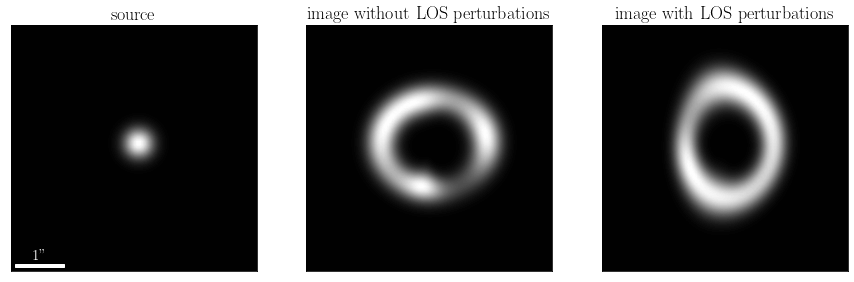

In [5]:
# Source profile

I0 = 1
centre = complex(0.1,0.1)
width = 0.2
Is = lambda beta: I0*Gaussian(beta, beta0=centre, sigma=width)


# Main lens

theta0=1 # Einstein radius
f=0.6 # axis ratio
phi0=np.pi/3 # orientation of semi-minor axis
alpha_d = lambda theta: alphaSIE(theta, theta0, f, phi0)


# Line-of-sight parameters

kappa_od=0
kappa_os=0
kappa_ds=0
gamma_od=0
gamma_os=-0.2
gamma_ds=0
F_od=0
F_os=0
F1_ds=0
F2_ds=0
G_od=0
G_os=0.05
G1_ds=0
G2_ds=0


# Compute profiles of the source an images

# grid for the images

xmin = -2.5
xmax = 2.5
ymin = -2.5
ymax = 2.5
nside = 100

grid = np.array([[theta1, theta2]
                 for theta1 in np.linspace(xmin, xmax, nside)
                 for theta2 in np.linspace(ymin, ymax, nside)])
x = grid[:,0]
y = grid[:,1]

# actual computations

source = np.array(
    [Is(complex(theta1, theta2))
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])

# image without the LOS perturbations
image = np.array(
    [Is(complex(theta1, theta2)-
       alpha(complex(theta1, theta2),
             alpha_d)
       )
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])

# image with the LOS perturbations
image_LOS = np.array(
    [Is(complex(theta1, theta2)-
       alpha(complex(theta1, theta2),
             alpha_d,
             kappa_od, gamma_od, F_od, G_od,
             kappa_os, gamma_os, F_os, G_os,
             kappa_ds, gamma_ds, F1_ds, G1_ds, F2_ds, G2_ds)
            )
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])


# Make the plots

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# plot the source
axs[0].tricontourf(x, y, source,
                   levels=np.linspace(0,I0,100),
                   cmap='gist_gray')
axs[0].set_title(r"source")

# plot the image without the LOS perturbation
axs[1].tricontourf(x, y, image, levels=np.linspace(0,I0,100), cmap='gist_gray')
axs[1].set_title(r"image without LOS perturbations")

# plot the image with the LOS perturbation
axs[2].tricontourf(x, y, image_LOS, levels=np.linspace(0,I0,100), cmap='gist_gray')
axs[2].set_title(r"image with LOS perturbations")

# indicate scale on source
scalebar = AnchoredSizeBar(axs[0].transData,
                           1, r'1"', 'lower left', 
                           pad=0.2,
                           color='white',
                           frameon=False,
                           label_top=True,
                           size_vertical=0.05)
axs[0].add_artist(scalebar);

# remove ticks and set aspect ratio
for ax in axs:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

## Shear-ellipticity degeneracy

We illustrate the degeneracy between the ellipticity of the main lens described by a singular isothermal ellipsoid (SIE) and the external shear.

ellipticity of the SIE: e=0.17647058823529416


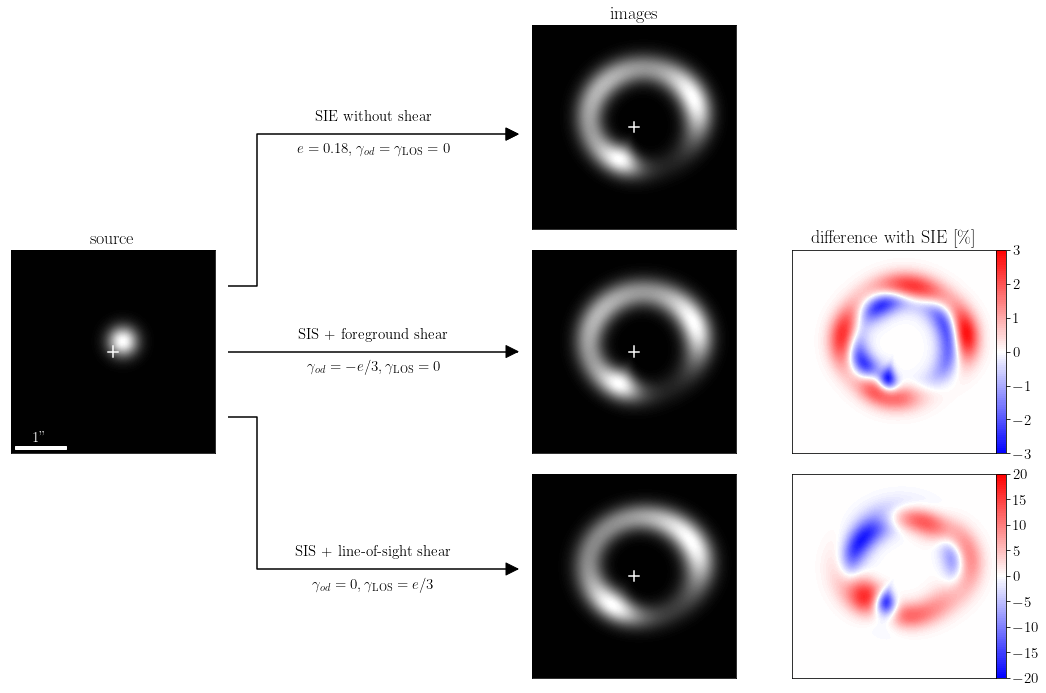

In [5]:
# Define the source

I0 = 1
#centre = complex(0.2,0.2)
centre=complex(0.2,0.2)
width = 0.2
Is = lambda beta: I0*Gaussian(beta, beta0=centre, sigma=width)


# Reference: elliptical lens

f = 0.7 # axis ratio
thetac = complex(0,0) # position of the centre of the lens
alpha_d = lambda theta: alphaSIE(theta-thetac,f=f)
e = (1-f)/(1+f) # ellipticity
print("ellipticity of the SIE: e="+str(e))


# Surface brightness of the source and images

# grid for the plots

xmin = -2
xmax = 2
ymin = -2
ymax = 2
nside = 100

grid = np.array([[theta1, theta2]
                 for theta1 in np.linspace(xmin, xmax, nside)
                 for theta2 in np.linspace(ymin, ymax, nside)])
x = grid[:,0]
y = grid[:,1]

# Source only
source = np.array(
    [Is(complex(theta1, theta2))
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])

# Image by SIE without shear
image_SIE = np.array(
    [Is(complex(theta1, theta2)
        - alpha(complex(theta1, theta2), alpha_d=alpha_d))
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])

# Image by SIS with foreground shear
# we fix gamma_od=-e/3 to mimic ellipticity
# we then set gamma_ds=gamma_od and gamma_os=0 to get gamma_LOS=0
# while having gamma_ds-gamma_od so that beta=beta_tilde
image_SIS_foreground = np.array(
    [Is(complex(theta1, theta2)
        - alpha(complex(theta1, theta2),
                alpha_d=alphaSIS,
                gamma_od=-e/3,
                gamma_ds=-e/3
               )
       )
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])

# Image by SIS with LOS shear
# we fix gamma_od=gamma_ds=0 and so that gamma_LOS=gamma_os
# and beta=beta_tilde again;
# then gamma_os=e/3 as a (failed) attempt to mimic ellipticity with LOS
image_SIS_LOS = np.array(
    [Is(complex(theta1, theta2)
        - alpha(complex(theta1, theta2),
                alpha_d=alphaSIS,
                gamma_os=e/3
               )
       )
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])

# Differences with SIE
diff_foreground_ellipticity = image_SIS_foreground - image_SIE
diff_LOS_ellipticity = image_SIS_LOS - image_SIE


# FIGURE

size_figure = 12
fig = plt.figure(figsize=(4/3*size_figure*1.2, size_figure))


# Arrangement of the plots

gs = fig.add_gridspec(3, 4)

ax_source = fig.add_subplot(gs[1, 0])
ax_arrows = fig.add_subplot(gs[:3, 1])
ax_SIE = fig.add_subplot(gs[0, 2])
ax_SIS_foreground = fig.add_subplot(gs[1, 2])
ax_diff_foreground = fig.add_subplot(gs[1, 3])
ax_SIS_LOS = fig.add_subplot(gs[2, 2])
ax_diff_LOS = fig.add_subplot(gs[2, 3])

axs = [ax_source,
       ax_SIE,
       ax_SIS_foreground, ax_diff_foreground,
       ax_SIS_LOS, ax_diff_LOS]


# Fill in the plots

# source and images
ax_source.tricontourf(x, y, source, levels=np.linspace(0,1,100), cmap='gist_gray')
ax_source.set_title(r"source")
ax_SIE.tricontourf(x, y, image_SIE, levels=np.linspace(0,1,100), cmap='gist_gray')
ax_SIE.set_title(r"images")
ax_SIS_foreground.tricontourf(x, y, image_SIS_foreground, levels=np.linspace(0,1,100), cmap='gist_gray')
ax_SIS_LOS.tricontourf(x, y, image_SIS_LOS, levels=np.linspace(0,1,100), cmap='gist_gray')

# arrows for legend
ax_arrows.text(0.5,5/6+0.02,r'SIE without shear', horizontalalignment='center')
ax_arrows.text(0.5,5/6-0.03,r'$e=0.18, \gamma_{od}=\gamma_{\rm LOS}=0$', horizontalalignment='center')
ax_arrows.add_artist(lines.Line2D([0, 0.1, 0.1, 1], [0.6, 0.6, 5/6, 5/6], color='k'))
ax_arrows.annotate("", xy=(1, 5/6), xytext=(0.99, 5/6), arrowprops=dict(facecolor='black'))

ax_arrows.text(0.5,1/2+0.02,r'SIS + foreground shear', horizontalalignment='center')
ax_arrows.text(0.5,1/2-0.03,r'$\gamma_{od}=-e/3, \gamma_{\rm LOS}=0$', horizontalalignment='center')
ax_arrows.add_artist(lines.Line2D([0, 1], [0.5, 0.5], color='k'))
ax_arrows.annotate("", xy=(1, 0.5), xytext=(0.99, 0.5), arrowprops=dict(facecolor='black'))

ax_arrows.text(0.5,1/6+0.02,r'SIS + line-of-sight shear', horizontalalignment='center')
ax_arrows.text(0.5,1/6-0.03,r'$\gamma_{od}=0, \gamma_{\rm LOS}=e/3$', horizontalalignment='center')
ax_arrows.add_artist(lines.Line2D([0, 0.1, 0.1, 1], [0.4, 0.4, 1/6, 1/6], color='k'))
ax_arrows.annotate("", xy=(1, 1/6), xytext=(0.99, 1/6), arrowprops=dict(facecolor='black'))

ax_arrows.annotate("", xy=(1, 5/6), xytext=(0.99, 5/6), arrowprops=dict(facecolor='black'))

# difference SIS+foreground - SIE
tcf_foreground=ax_diff_foreground.tricontourf(x, y, 100*diff_foreground_ellipticity,
                           levels=np.linspace(-3,3,100),
                           cmap='bwr')
ax_diff_foreground.set_title(r"difference with SIE [\%]")
fig.colorbar(tcf_foreground, ax=ax_diff_foreground, pad=0, ticks=np.linspace(-3,3,7))

# difference SIS+LOS - SIE
tcf_LOS=ax_diff_LOS.tricontourf(x, y, 100*diff_LOS_ellipticity,
                           levels=np.linspace(-20,20,100),
                           cmap='bwr')
fig.colorbar(tcf_LOS, ax=ax_diff_LOS, pad=0, ticks=np.linspace(-20,20,9))
    
    
# Aesthetics

fig.subplots_adjust(wspace=-0.1, hspace=0.1)

for ax in axs:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
ax_arrows.axis("off")
    
    
# Indicate scale on the source

scalebar = AnchoredSizeBar(ax_source.transData,
                           1, r'1"', 'lower left', 
                           pad=0.2,
                           color='white',
                           frameon=False,
                           label_top=True,
                           size_vertical=0.05)
axs[0].add_artist(scalebar);


# Add crosses to indicate the centre of the lens

ax_source.add_artist(lines.Line2D([-0.1, 0.1], [0, 0], color='white'))
ax_source.add_artist(lines.Line2D([0, 0], [-0.1, 0.1], color='white'))

ax_SIE.add_artist(lines.Line2D([-0.1, 0.1], [0, 0], color='white'))
ax_SIE.add_artist(lines.Line2D([0, 0], [-0.1, 0.1], color='white'))

ax_SIS_foreground.add_artist(lines.Line2D([-0.1, 0.1], [0, 0], color='white'))
ax_SIS_foreground.add_artist(lines.Line2D([0, 0], [-0.1, 0.1], color='white'))

ax_SIS_LOS.add_artist(lines.Line2D([-0.1, 0.1], [0, 0], color='white'))
ax_SIS_LOS.add_artist(lines.Line2D([0, 0], [-0.1, 0.1], color='white'))


# Save figure
#fig.savefig("figures/ellipticity_vs_shear.png",
#            format='png', dpi=300, transparent=True, bbox_inches='tight')

## Illustrate flexion without strong lensing

This shows the effect of a pure $\mathcal{F}$-type flexion of a pure $\mathcal{G}$-type flexion.

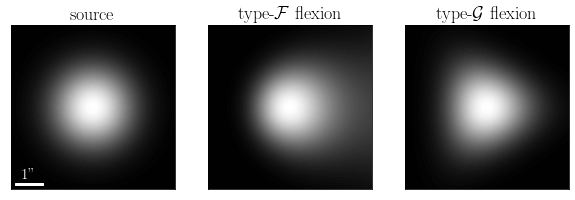

In [6]:
# Choice of a source

I0 = 1
centre = 0
width = 1
Is = lambda beta: I0*Gaussian(beta, beta0=centre, sigma=width)


# No main deflector

alpha_d = lambda theta: 0


# Grid for the images

xmin = -3
xmax = 3
ymin = -3
ymax = 3
nside = 100

grid = np.array([[theta1, theta2]
                 for theta1 in np.linspace(xmin, xmax, nside)
                 for theta2 in np.linspace(ymin, ymax, nside)])
x = grid[:,0]
y = grid[:,1]


# Generate the source and images

# Source only
source = np.array(
    [Is(complex(theta1, theta2))
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])

# Pure Fos 
imageF = np.array(
    [Is(complex(theta1, theta2) - alpha(complex(theta1, theta2), alpha_d=alpha_d, F_os=0.1))
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])

# Pure Gos 
imageG = np.array(
    [Is(complex(theta1, theta2) - alpha(complex(theta1, theta2), alpha_d=alpha_d, G_os=0.1))
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])


# Plot the images

images = [source, imageF, imageG]
titles = ["source", r"type-$\mathcal{F}$ flexion", r"type-$\mathcal{G}$ flexion"]
fig, ax = plt.subplots(nrows=1, ncols=len(images), figsize=(10,10))

for i, image in enumerate(images):
    ax[i].tricontourf(x, y, image,levels=np.linspace(0,1,100),cmap='gist_gray')
    ax[i].set_aspect('equal')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(titles[i])

# Indicate scale on the first one
scalebar = AnchoredSizeBar(ax[0].transData,
                           1, r'1"', 'lower left', 
                           pad=0.2,
                           color='white',
                           frameon=False,
                           label_top=True,
                           size_vertical=0.05)
ax[0].add_artist(scalebar);
    
#fig.savefig("figures/pure_flexion.png",
#            format='png', dpi=300, transparent=True, bbox_inches='tight')

## Effect of flexion on Einstein rings

Choice of parameters and properties of the grid

In [6]:
# Choice of a source

I0 = 1
centre = 0
width = 0.2
Is = lambda beta: I0*Gaussian(beta, beta0=centre, sigma=width)


# Lensing features

alpha_d = alphaSIS # main deflector
F = 0.1 # flexion amplitude


# Grid for the images

xmin = -2.5
xmax = 2.5
ymin = -2.5
ymax = 2.5
nside = 100

grid = np.array([[theta1, theta2]
                 for theta1 in np.linspace(xmin, xmax, nside)
                 for theta2 in np.linspace(ymin, ymax, nside)])
x = grid[:,0]
y = grid[:,1]

Images for type-$\mathcal{F}$ flexion

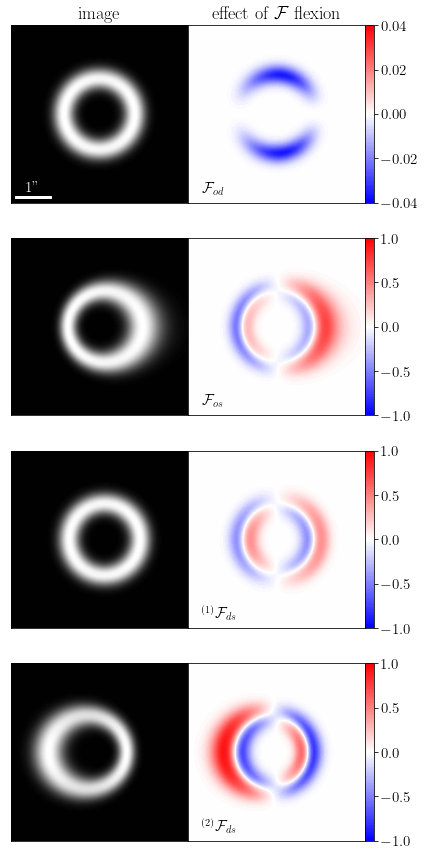

In [11]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,15))
fig.subplots_adjust(wspace=-0.76)

# without flexion
imnoflex = np.array([Is(complex(theta1, theta2)-alpha_d(complex(theta1, theta2)))
                     for theta1 in np.linspace(xmin, xmax, nside)
                     for theta2 in np.linspace(ymin, ymax, nside)
                    ])

# with flexion

modes=[r'$\mathcal{F}_{od}$',
      r'$\mathcal{F}_{os}$',
      r'${}^{(1)}\mathcal{F}_{ds}$',
      r'${}^{(2)}\mathcal{F}_{ds}$']

for i in range(4):
    image = np.array(
        [Is(complex(theta1, theta2)
            - alpha(complex(theta1, theta2),
                    alpha_d=alpha_d,
                    F_od=delta(i,0)*F,
                    F_os=delta(i,1)*F,
                    F1_ds=delta(i,2)*F,
                    F2_ds=delta(i,3)*F
                   )
           )
         for theta1 in np.linspace(xmin, xmax, nside)
         for theta2 in np.linspace(ymin, ymax, nside)
            ]
    )
    
    # first colum: images
    ax=axs[i,0]
    ax.tricontourf(x, y, image,levels=np.linspace(0,1,100),cmap='gist_gray')
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # second column: corrections due to flexion only
    residuals = image - imnoflex
    ax=axs[i,1]
    
    if i==0: # case of (od): adapt the scale
        tcf=ax.tricontourf(x, y, residuals,levels=np.linspace(-0.04,0.04,100),cmap='bwr')
        fig.colorbar(tcf, ax=ax, ticks=np.linspace(-0.04,0.04,5), pad=0)
    else: # otherwise normal scale
        tcf=ax.tricontourf(x, y, residuals,levels=np.linspace(-1,1,100),cmap='bwr')
        fig.colorbar(tcf, ax=ax, ticks=np.linspace(-1,1,5), pad=0)
    ax.text(-2.1, -2.2, modes[i], horizontalalignment='left')
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
# Set titles on the first row
axs[0,0].set_title(r"image")
axs[0,1].set_title(r"effect of $\mathcal{F}$ flexion")

# Indicate scale on the first figure
scalebar = AnchoredSizeBar(axs[0,0].transData,
                           1, r'1"', 'lower left', 
                           pad=0.2,
                           color='white',
                           frameon=False,
                           label_top=True,
                           size_vertical=0.05)
axs[0,0].add_artist(scalebar);

# Save figure
fig.savefig(path+"effect_F_flexion.png",
            format='png',
            dpi=300,
            transparent=True,
            bbox_inches='tight')

Images for type-$\mathcal{G}$ flexion

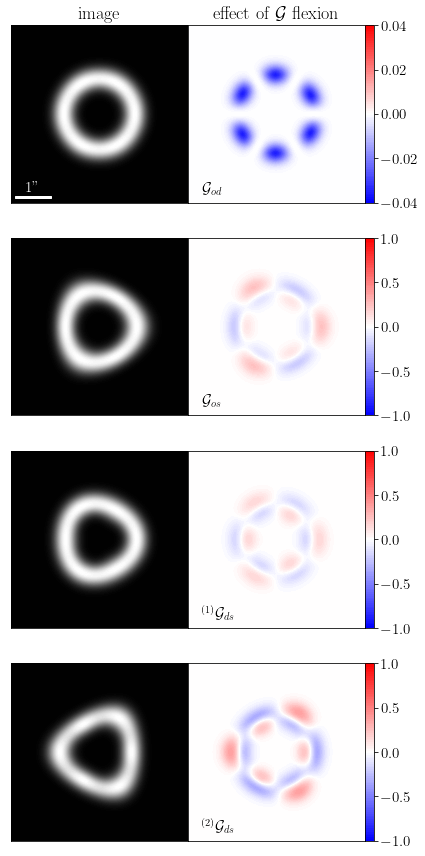

In [12]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,15))
fig.subplots_adjust(wspace=-0.76)

# without flexion
imnoflex = np.array([Is(complex(theta1, theta2)-alpha_d(complex(theta1, theta2)))
                     for theta1 in np.linspace(xmin, xmax, nside)
                     for theta2 in np.linspace(ymin, ymax, nside)
                    ])

# with flexion

modes=[r'$\mathcal{G}_{od}$',
      r'$\mathcal{G}_{os}$',
      r'${}^{(1)}\mathcal{G}_{ds}$',
      r'${}^{(2)}\mathcal{G}_{ds}$']

for i in range(4):
    image = np.array(
        [Is(complex(theta1, theta2)
            - alpha(complex(theta1, theta2),
                    alpha_d=alpha_d,
                    G_od=delta(i,0)*F,
                    G_os=delta(i,1)*F,
                    G1_ds=delta(i,2)*F,
                    G2_ds=delta(i,3)*F
                   )
           )
         for theta1 in np.linspace(xmin, xmax, nside)
         for theta2 in np.linspace(ymin, ymax, nside)
            ]
    )
    
    # first colum: images
    ax=axs[i,0]
    ax.tricontourf(x, y, image,levels=np.linspace(0,1,100),cmap='gist_gray')
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # second column: corrections due to flexion only
    residuals = image - imnoflex
    ax=axs[i,1]
    
    if i==0: # case of (od): adapt the scale
        tcf=ax.tricontourf(x, y, residuals,levels=np.linspace(-0.04,0.04,100),cmap='bwr')
        fig.colorbar(tcf, ax=ax, ticks=np.linspace(-0.04,0.04,5), pad=0)
    else: # otherwise normal scale
        tcf=ax.tricontourf(x, y, residuals,levels=np.linspace(-1,1,100),cmap='bwr')
        fig.colorbar(tcf, ax=ax, ticks=np.linspace(-1,1,5), pad=0)
    ax.text(-2.1, -2.2, modes[i], horizontalalignment='left')
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
# Set titles on the first row
axs[0,0].set_title(r"image")
axs[0,1].set_title(r"effect of $\mathcal{G}$ flexion")

# Indicate scale on the first figure
scalebar = AnchoredSizeBar(axs[0,0].transData,
                           1, r'1"', 'lower left', 
                           pad=0.2,
                           color='white',
                           frameon=False,
                           label_top=True,
                           size_vertical=0.05)
axs[0,0].add_artist(scalebar);

# Save figure
fig.savefig(path+"effect_G_flexion.png",
            format='png',
            dpi=300,
            transparent=True,
            bbox_inches='tight')

# Dominant lens with discrete perturbers

This section considers discrete perturbers (rather than shear and flexion parameters) on the LOS. We also focus on critical curves.

In all the section, we neglect cosmic expansion for simplicity, so that distances are comoving distances and are additive.

The main lens is taken as a SIS.

Units:
- angles are expressed in arcsec (arbitrary)
- distances are in Gpc (arbitrary)
- masses are such that $4G/c^2=1$

In [10]:
# Parameters for the main lens (SIS)

chi_s = 1 # comoving distance to the source
chi_d = chi_s/2 # comoving distance to the main lens
theta_E = 1 # Einstein radius main lens
kappa_E = 1/2 # for a SIS
M_E = np.pi*theta_E**2*chi_d*chi_s/(chi_s-chi_d) # mass enclosed in Einstein radius

## Perturbers

We take isolated haloes with cores, described by a deflection angle
$$
\underline{\hat{\alpha}}(\underline{x})
= \frac{4Gm}{\underline{x}^*} \left[ \frac{x^4}{x^4 + r_{\rm c}^4} \right]^{1/2} \ ,
$$
where $m$ is the mass of the perturber and $r_{\rm c}$ the core radius.

The corresponding displacement angle, convergence and shear for the $l$th lens read
\begin{align}
\underline{\alpha}_{ilj}(\underline{x}_l)
&=
\frac{D_{lj}}{D_{ij}} \,
\underline{\hat{\alpha}}_l(\underline{x}_l)
\\
\kappa_{ilj}(\underline{x}_l)
&=
\frac{4\pi G D_{il}D_{lj}}{D_{ij}} \,
\Sigma_l(\underline{x}_l)
\qquad
\Sigma_l(\underline{x}_l)
= \frac{m}{\pi r_{\rm c}^2}
\left[ \frac{r_{\rm c}^4}{x_l^4 + r_{\rm c}^4} \right]^{3/2}
\\
\gamma_{ilj}(\underline{x}_l)
&=
\frac{4\pi G D_{il}D_{lj}}{D_{ij}} \,
Q_l(\underline{x}_l)
\qquad
Q_l(\underline{x}_l)
= -\frac{m}{\pi r_{\rm c}^2}
\left(\frac{r_{\rm c}}{\underline{x}_l^*}\right)^2
\left[ \frac{x_l^4}{x_l^4 + r_{\rm c}^4} \right]^{3/2}
= -\Sigma_l(\underline{x}_l) \,
\left(\frac{x_l}{r_{\rm c}}\right)^2
\left(\frac{\underline{x}_l}{r_{\rm c}}\right)^2
\end{align}

In [11]:
class Perturber:
    """Object containing the properties of a given perturber
generated randomly. I define a class here to make
the rest of the procedure more readable."""
    
    def __init__(self, m, rc, rmax, chi_s=chi_s):
        """Creates random perturber with mass m at a maximum comoving
distance rmax from the optical axis. The arguments are:
1. m, the mass of the perturber
2. rc, the radius of the core
3. rmax, the maximum distance from the optical axis."""
        
        self.m = m # mass of the perturber
        self.rc = rc # radius of the core
        
        chi = chi_s*np.random.rand() # comoving distance from observer
        self.chi = chi
        
        r = rmax*np.random.rand() # distance from optical axis
        phi = 2*np.pi*np.random.rand() # azimuthal angle about optical axis
        self.centre = complex(r*np.cos(phi), r*np.sin(phi)) # transverse position
        
        self.Sigma0 = m/np.pi/rc**2 # core density
        
        
    def __repr__(self):
        return """Perturber:
m = {}
rc = {}
chi = {}
centre = {}""".format(self.m, self.rc, self.chi, self.centre)
    
    def deflection(self, x):
        """Deflection angle of the perturber.
Take a complex position x as an argument."""
        
        y = x - self.centre # relative position wrt perturber centre
        
        return self.m/y.conjugate()*( 1 + self.rc**4/abs(y)**4 )**(-1/2)
    
    
    def Sigma(self, x):
        """Local surface density of the perturber.
Take a complex position x as an argument."""
        
        y = x - self.centre # relative position wrt perturber centre
        sigma = self.Sigma0*(1 + abs(y)**4/self.rc**4 )**(-3/2)
        
        return sigma
        
        
    def Q(self, x):
        """Local shear density of the perturber.
Take a complex position x as an argument."""
        
        y = x - self.centre # relative position wrt perturber centre
        
        q = - self.Sigma0*( self.rc/y.conjugate() )**2
        q *= (1 + (self.rc**4/abs(y)**4) )**(-3/2)
        
        return q

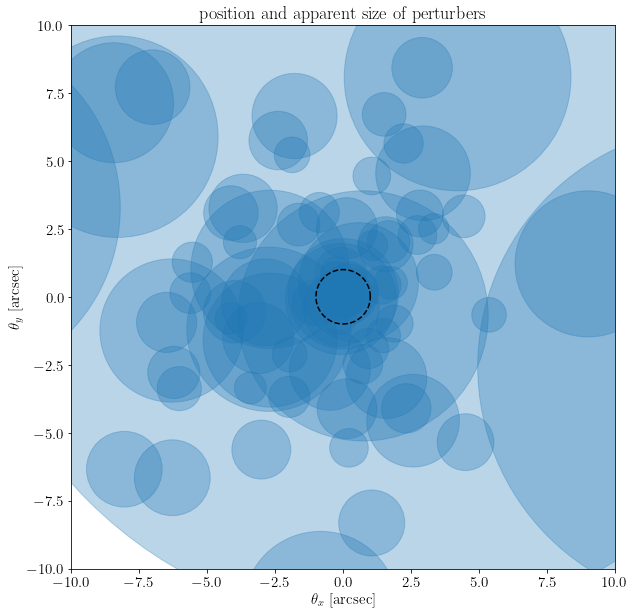

In [12]:
# Generate N random perturbers

N = 100 # number of perturbers
m = M_E/N # mass of the perturbers
Sigma0 = 4/np.pi/10 # central density of the perturbers
# I chose it to be 5 times smaller than the critical
# density in the main lens plane here.
rc = (m/np.pi/Sigma0)**(1/2) # core radius
rmax = 5*chi_s*theta_E # maximum comoving distance from the optical axis

perturbers = [Perturber(m, rc, rmax) for i in range(N)]


# Show where they are with the apparent size of the core

# Unperturbed critical curve for the scale
phi = np.linspace(0, 2*np.pi, 60)
CCx = np.array([theta_E*np.cos(ph) for ph in phi])
CCy = np.array([theta_E*np.sin(ph) for ph in phi])

size_figure = 10
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(size_figure, size_figure))
ax.plot(CCx, CCy, 'k--')

x = []
y = []
r = []

for perturber in perturbers:
    
    x.append(perturber.centre.real/perturber.chi)
    y.append(perturber.centre.imag/perturber.chi)
    r.append(perturber.rc/perturber.chi)

x=np.array(x)
y=np.array(y)
r=np.array(r)

ax.scatter(x, y,
            s=np.pi*(6*r*size_figure)**2, # to have the correct core size
            alpha=0.3)    
ax.axis([-10, 10, -10, 10])
ax.set_aspect('equal')
ax.set_xlabel(r'$\theta_x$ [arcsec]')
ax.set_ylabel(r'$\theta_y$ [arcsec]')
ax.set_title(r'position and apparent size of perturbers');

## Effect of the perturbers on images

In [13]:
# Displacement angle in the DL approximation

def alphaDL(theta, perturbers, alpha_ods=alphaSIS):
    """Displacement angle due to a dominant lens
with discrete perturbers."""

    alpha_od = 0 # post-Born for main lens
    alpha_os = 0 # direct displacement
    
    for perturber in perturbers:
        
        # position along the los
        chi = perturber.chi
        
        # transverse position of the unperturbed ray
        x = theta*chi - max(0,(chi-chi_d)*chi_s/chi/(chi_s-chi_d))*alpha_ods(theta)
        
        # post-Born correction for main lens
        alpha_od += max(0, (chi_d-chi)/chi_d) * perturber.deflection(x)
        
        # direct displacement
        alpha_os += (chi_s-chi)/chi_s * perturber.deflection(x)
    
    
    # Result
    
    return alpha_ods(theta-alpha_od) + alpha_os

Illustration

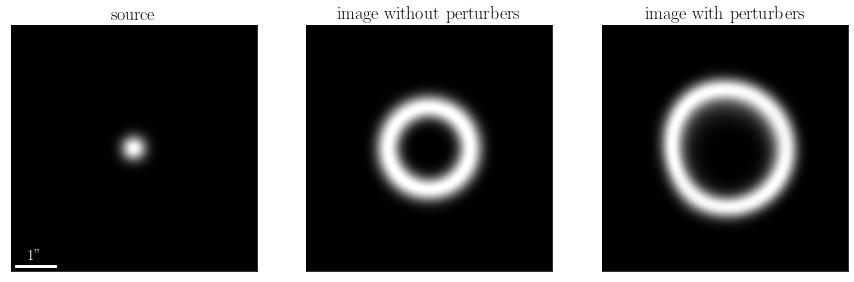

In [14]:
# Source profile

I0 = 1
centre = complex(0,0)
width = 0.2
Is = lambda beta: I0*Gaussian(beta, beta0=centre, sigma=width)


# Compute source and image profiles

# grid for the images

xmin = -3
xmax = 3
ymin = -3
ymax = 3
nside = 100

grid = np.array([[theta1, theta2]
                 for theta1 in np.linspace(xmin, xmax, nside)
                 for theta2 in np.linspace(ymin, ymax, nside)])
x = grid[:,0]
y = grid[:,1]

# actual computations

source = np.array(
    [Is(complex(theta1, theta2))
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])

imageSIS = np.array(
    [Is(complex(theta1, theta2)-
       alphaSIS(complex(theta1, theta2))
            )
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])

imageSISpert = np.array(
    [Is(complex(theta1, theta2)-
       alphaDL(complex(theta1, theta2), perturbers)
            )
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])


# Make the plots

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# plot the source
axs[0].tricontourf(x, y, source,
                   levels=np.linspace(0,I0,100),
                   cmap='gist_gray')
axs[0].set_title(r"source")

# plot the image without perturbers
axs[1].tricontourf(x, y, imageSIS, levels=np.linspace(0,I0,100), cmap='gist_gray')
axs[1].set_title(r"image without perturbers")

# plot the image with perturbers
axs[2].tricontourf(x, y, imageSISpert, levels=np.linspace(0,I0,100), cmap='gist_gray')
axs[2].set_title(r"image with perturbers")

# indicate scale on source
scalebar = AnchoredSizeBar(axs[0].transData,
                           1, r'1"', 'lower left', 
                           pad=0.2,
                           color='white',
                           frameon=False,
                           label_top=True,
                           size_vertical=0.05)
axs[0].add_artist(scalebar);

# remove ticks and set aspect ratio
for ax in axs:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

## Perturbations of critical curves

The polar equation of the perturbed critical curve reads
$$
\theta_{\rm cc}(\varphi) = \theta_{\rm E} + \delta\theta_{\rm cc}(\varphi)
\qquad
\text{with}
\qquad
\delta\theta(\varphi)
= \Re\left[
        \mathrm{e}^{-\mathrm{i}\varphi}
        \underline{\alpha}_{od}(\varphi)
        \right]
    +
   \frac{\theta_{\rm E}}{2(1-\kappa_{\rm E})}
        \left\{
            \kappa_{\rm ext}(\varphi)
            - \Re\left[
                        \mathrm{e}^{-2\mathrm{i}\varphi}
                        \gamma_{\rm ext}(\varphi)
                 \right]
        \right\}
$$
where
\begin{align}
\underline{\alpha}_{od}(\varphi)
&= \sum_{l<d} \frac{D_{ld}}{D_{od}} \,
                \hat{\underline{\alpha}}_l(R_l\mathrm{e}^{\mathrm{i}\varphi})
\\
\kappa_{\rm ext}(\varphi)
&= \sum_{l<d}
    \left(
    \frac{1}{\Sigma^{\rm crit}_{ols}}
    - \frac{1}{\Sigma^{\rm crit}_{old}}
    \right) \,
    \Sigma_l(R_l\mathrm{e}^{\mathrm{i}\varphi})
    +
    \sum_{l>d}
    \left(
    \frac{1}{\Sigma^{\rm crit}_{ols}}
    - \frac{1}{\Sigma^{\rm crit}_{dls}}
    \right) \,
    \Sigma_l(R_l\mathrm{e}^{\mathrm{i}\varphi})
\\
\gamma_{\rm ext}(\varphi)
&= \sum_{l<d}
    \left(
    \frac{1}{\Sigma^{\rm crit}_{ols}}
    - \frac{1}{\Sigma^{\rm crit}_{old}}
    \right) \,
    Q_l(R_l\mathrm{e}^{\mathrm{i}\varphi})
    +
    \sum_{l>d}
    \left(
    \frac{1}{\Sigma^{\rm crit}_{ols}}
    - \frac{1}{\Sigma^{\rm crit}_{dls}}
    \right)\,
    Q_l(R_l\mathrm{e}^{\mathrm{i}\varphi})
\end{align}
and where $R_l$ is the unperturbed critical beam's radius at the $l$th plane,
$$
R_l
=
\theta_{\rm E}\times
\begin{cases}
D_{ol} & l\leq d \\
\frac{1+z_d}{1+z_l}\frac{D_{od}D_{ls}}{D_{ds}}& l\geq d
\end{cases}
$$

In [15]:
# Perturbation to the critical curve

def Rcrit(chi):
    """Comoving radius of the critical beam adapted
to the double-cone geometry."""
    
    if chi<chi_d:
        return theta_E*chi
    else:
        return theta_E*chi*(chi_s-chi)/(chi_s-chi_d)

    
def dtheta(phi, perturbers):
    """Perturbation to the critical curve
as a function of the azimuthal angle."""
    
    u = complex(np.cos(phi), np.sin(phi))
    
    # initialise perturbations
    dtheta = 0
    dtheta_od = 0
    kappa_gamma_ext = 0
    
    for perturber in perturbers:
    
        chi = perturber.chi # position along the los
        R = Rcrit(chi) # radius of the critical beam there
        
        # contribution to dtheta_od
        distratio = max(0, (chi_d-chi)/chi_d)
        dalpha_od = perturber.deflection(R*u)
        #-perturber.deflection(0)
        dtheta_od += distratio*(dalpha_od/u).real
        
        # contribution to kappa_ext and gamma_ext
        invSigma_os = np.pi*chi*(chi_s-chi)/chi_s
        invSigma_od = np.pi*chi*max(0, chi_d-chi)/chi_d
        invSigma_ds = np.pi*(chi_s-chi)*max(0, chi-chi_d)/(chi_s-chi_d)
        invSigma_tot = (invSigma_os - invSigma_ds - invSigma_od)
        
        Sigma = perturber.Sigma(R*u)
        Q = perturber.Q(R*u)
        
        kappa_gamma_ext += invSigma_tot*( Sigma - (Q/u**2).real )
        
        
    dtheta = dtheta_od + theta_E/2/(1-kappa_E)*kappa_gamma_ext
    
    return dtheta

Modes of the critical curve

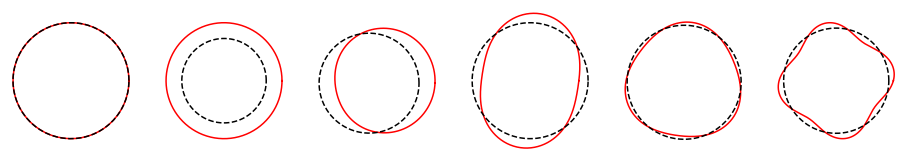

In [16]:
# Compute critical curve

phi = np.linspace(0, 2*np.pi, 360)
CC = np.array([theta_E+dtheta(ph, perturbers) for ph in phi])
CC = CC[:-1]


# Compute the first modes

n_modes = 5
crit_modes = []

for n in range(n_modes):
    
    basis = np.exp(-1j*n*phi)
    basis = basis[:-1]
    dphi = phi[1:]-phi[:-1]
    mode = np.dot(CC*basis, dphi)
    mode/=(2*np.pi*theta_E)
    
    crit_modes.append(mode)
    
    
# Plot the modes

fig, axs = plt.subplots(nrows=1, ncols=n_modes+1, figsize=(3*n_modes+1, 3))

# complete critical curve
axs[0].plot(CCx, CCy, 'r')

# single modes only
for n, mode in enumerate(crit_modes):
    
    if n==0: # isolate the real n=0 case
        r = mode.real
    
    else: # radius for the nth mode only
        mag = 5 # magnify the effect to make it visible
        r = [theta_E+2*mag*(mode*np.exp(n*1j*ph)).real for ph in phi]
        r = np.array(r)
        
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    
    ax = axs[n+1]
    ax.plot(x, y, 'r')
    
# aesthetics
for ax in axs:
    ax.plot(theta_E*np.cos(phi), theta_E*np.sin(phi), 'k--')
    ax.set_aspect('equal')
    ax.axis('off')
    
# Save figure

#fig.savefig("figures/critical_modes.pdf",
#           format='pdf',
#            transparent=True,
#            bbox_inches='tight')

In [17]:
# To check cc calculation: compute the magnification

def magnification(theta, perturbers):
    """Inverse magnification field in image plane."""
    
    # convergence and shear of the main lens (SIS)
    kappa_ods = theta_E/2/abs(theta)
    gamma_ods = - theta_E*theta**2/2/abs(theta)**3
    
    # initialise perturbations
    alpha_od = 0
    kappa_od = 0
    kappa_ds = 0
    kappa_os = 0
    gamma_ext = 0
    

    for perturber in perturbers:
        
        chi = perturber.chi
        
        # transverse position of the unperturbed ray
        x = theta*chi - max(0,(chi-chi_d)*chi_s/chi/(chi_s-chi_d))*alphaSIS(theta)
        
        # incrementing
        alpha_od += max(0, (chi_d-chi)/chi_d) * perturber.deflection(x)
        
        invSigma_od = np.pi*chi*max(0, chi_d-chi)/chi_d
        invSigma_ds = np.pi*(chi_s-chi)*max(0, chi-chi_d)/(chi_s-chi_d)
        invSigma_os = np.pi*chi*(chi_s-chi)/chi_s
        
        Sigma = perturber.Sigma(x)
        Q = perturber.Q(x)
        
        kappa_od += invSigma_od * Sigma
        kappa_ds += invSigma_ds * Sigma
        kappa_os += invSigma_os * Sigma
        
        gamma_ext += (invSigma_od+invSigma_ds-invSigma_os) * Q
        
        
    # Add all the ingredients to the result
    
    invmu_ods = 1-1/abs(theta-alpha_od) # main lens
    invmu = ( 1-2*(kappa_od+kappa_ds) )*invmu_ods
    kappa_ext = kappa_od+kappa_ds-kappa_os
    invmu += 2*(1-kappa_ods)*kappa_ext
    invmu += 2*( gamma_ods.conjugate()*gamma_ext ).real
    
    return 1/abs(invmu)

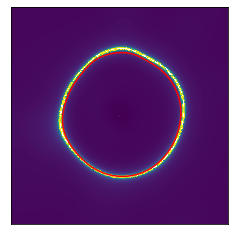

In [18]:
# Plot both the magnification and the theoretical cc
# to check that the profiles match


xmin = -2.5
xmax = 2.5
ymin = -2.5
ymax = 2.5
nside = 200

grid = np.array([[theta1, theta2]
                 for theta1 in np.linspace(xmin, xmax, nside)
                 for theta2 in np.linspace(ymin, ymax, nside)])
x = grid[:,0]
y = grid[:,1]


# Compute magnification field

mu = np.array(
    [magnification(complex(theta1, theta2), perturbers)
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])


# Compute critical curve

phi = np.linspace(0, 2*np.pi, 360)
CCx = np.array([(theta_E+dtheta(ph, perturbers))*np.cos(ph) for ph in phi])
CCy = np.array([(theta_E+dtheta(ph, perturbers))*np.sin(ph) for ph in phi])


# Make the plots

plt.tricontourf(x, y, mu, levels=np.linspace(0,100,500))
plt.plot(CCx, CCy, color='r')
   
plt.gca().set_xticks([])
plt.gca().set_yticks([]);
plt.gca().set_aspect('equal')

Agreement is reasonably good. Departures appear when the perturbers are denser (nearly critical or critical), because the DL approximation breaks down. We do not expect this to happen in practice, because the distortions would be quite smaller.

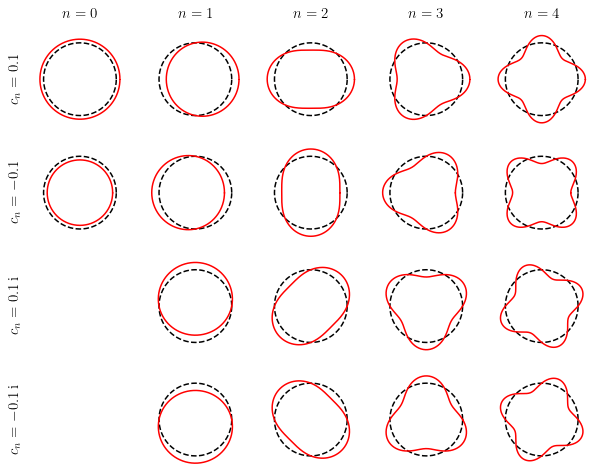

In [28]:
# General illustration of individual critical modes

phi = np.linspace(0, 2*np.pi, 360, endpoint=False)
c = 0.1 # amplitude of each mode
modes = c * np.array([1,-1,1j,-1j])
mode_titles = [r'$c_n=0.1$',
               r'$c_n=-0.1$',
               r'$c_n=0.1\,\mathrm{i}$',
               r'$c_n=-0.1\,\mathrm{i}$']

nmax = 4 # maximum order of the modes plotted

fig, axs = plt.subplots(4, nmax+1, figsize=(2*(nmax+1),8))

for n in range(nmax+1):
    
    for p, mode in enumerate(modes):
        
        ax = axs[p, n]
        
        if (n,p) != (0,2) and (n,p) != (0,3):
            
            if n == 0: # c0 contributes onces, the others contribute twice
                m = 1
            else:
                m = 2
            
            r = [1 + m * (mode * np.exp(-n*1j*ph)).real for ph in phi]
            r = np.array(r)
            
            ax.plot(np.cos(phi), np.sin(phi), 'k--')
            ax.plot(r*np.cos(phi), r*np.sin(phi), 'r')
        
        ax.set_aspect('equal')
        ax.axis([-1.3, 1.3, -1.3, 1.3])
        ax.axis('off')
        
        # add legends
        
        if p==0:
            ax.text(0, 1.7, r'$n={}$'.format(n),
                   horizontalalignment='center')
        
        if n==0:
            ax.text(-2, 0, mode_titles[p],
                    rotation=90,
                   verticalalignment='center')
            
fig.savefig("figures/illustration_modes.pdf",
           format='pdf',
            transparent=True,
            bbox_inches='tight')

## Everything in one plot for the article

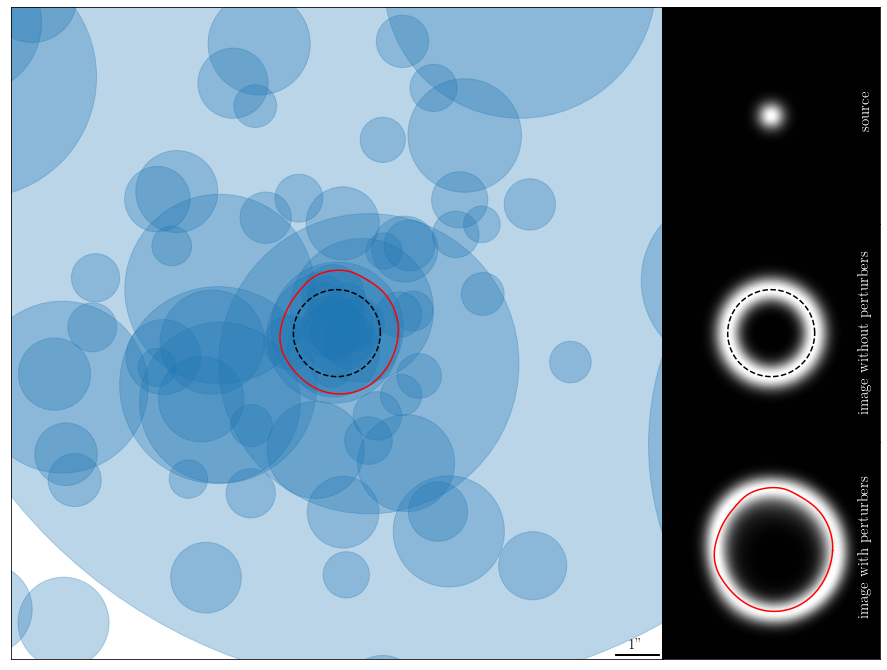

In [20]:
# SOURCE AND IMAGES

I0 = 1
centre = complex(0,0)
width = 0.2
Is = lambda beta: I0*Gaussian(beta, beta0=centre, sigma=width)


# Compute source and image profiles

# grid for the images

xmin = -2.5
xmax = 2.5
ymin = -2.5
ymax = 2.5
nside = 100

grid = np.array([[theta1, theta2]
                 for theta1 in np.linspace(xmin, xmax, nside)
                 for theta2 in np.linspace(ymin, ymax, nside)])
x = grid[:,0]
y = grid[:,1]


# computations

source = np.array(
    [Is(complex(theta1, theta2))
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])

imageSIS = np.array(
    [Is(complex(theta1, theta2)-
       alphaSIS(complex(theta1, theta2))
            )
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])

imageSISpert = np.array(
    [Is(complex(theta1, theta2)-
       alphaDL(complex(theta1, theta2), perturbers)
            )
     for theta1 in np.linspace(xmin, xmax, nside)
     for theta2 in np.linspace(ymin, ymax, nside)])


# CRITICAL CURVES

phi = np.linspace(0, 2*np.pi, 360)
CCx = np.array([theta_E*np.cos(ph) for ph in phi])
CCy = np.array([theta_E*np.sin(ph) for ph in phi])
CCpertx = np.array([(theta_E+dtheta(ph, perturbers))*np.cos(ph) for ph in phi])
CCperty = np.array([(theta_E+dtheta(ph, perturbers))*np.sin(ph) for ph in phi])


# FIGURE

size_figure = 12
fig = plt.figure(figsize=(4*size_figure/3, size_figure))


# arrangement of the plots

gs = fig.add_gridspec(3, 4)

axfield = fig.add_subplot(gs[:3, :3])
axsource = fig.add_subplot(gs[0, -1])
aximage_wo = fig.add_subplot(gs[1, -1])
aximage_w = fig.add_subplot(gs[2, -1])

fig.subplots_adjust(wspace=-0.1, hspace=0)


# Left panel: show the perturbers

thetax = [] # x of perturbers' centres
thetay = [] # y of perturbers' centres
r = [] # physical radius of cores (all identical here actually)

for perturber in perturbers:
    
    thetax.append(perturber.centre.real/perturber.chi)
    thetay.append(perturber.centre.imag/perturber.chi)
    r.append(perturber.rc/perturber.chi)

thetax=np.array(thetax)
thetay=np.array(thetay)
r=np.array(r)

axfield.scatter(thetax, thetay,
            s=np.pi*(6*r*size_figure)**2, # to display the correct core size
            alpha=0.3)    
axfield.axis([-7.5, 7.5, -7.5, 7.5])


# add the critical curves
axfield.plot(CCx, CCy, 'k--')
axfield.plot(CCpertx, CCperty, 'r')

# indicate scale
scalebar = AnchoredSizeBar(axfield.transData,
                           1, r'1"', 'lower right', 
                           pad=0.2,
                           color='k',
                           frameon=False,
                           label_top=True,
                           size_vertical=0.02)
axfield.add_artist(scalebar);


# Right panel: source and inages for illustration

# plot the source
axsource.tricontourf(x, y, source,
                   levels=np.linspace(0,I0,100),
                   cmap='gist_gray')
axsource.text(2, -0.3, 'source', color='w', rotation=90)


# plot the image without perturbers
aximage_wo.tricontourf(x, y, imageSIS, levels=np.linspace(0,I0,100), cmap='gist_gray')
aximage_wo.plot(CCx, CCy, 'k--')
aximage_wo.text(2, -1.8, 'image without perturbers', color='w', rotation=90)


# plot the image with perturbers
aximage_w.tricontourf(x, y, imageSISpert, levels=np.linspace(0,I0,100), cmap='gist_gray')
aximage_w.plot(CCpertx, CCperty,'r')
aximage_w.text(2, -1.5, 'image with perturbers', color='w', rotation=90)


# Aesthetics

for ax in [axfield, axsource, aximage_wo, aximage_w]:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
# Save figure

#fig.savefig("figures/discrete_deflectors.png",
#           format='png',
#            dpi=300,
#            transparent=True,
#            bbox_inches='tight')

# Cosmology

## Line-of-sight weighting functions

Weighting function for the measurable external shear $\gamma_{\rm LOS}$, compared with the standard one of cosmic shear.

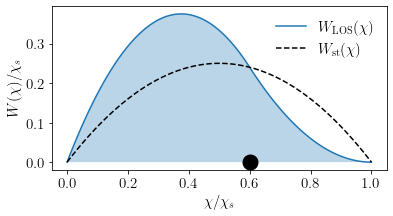

In [21]:
# Set parameters

chi_s = 1
chi_d = 0.6*chi_s


# Define the functions to be plotted

def W_os(chi):
    "Weight function for standard cosmic shear."
    
    W = chi*(chi_s-chi)/chi_s
    
    return W


def W_LOS(chi):
    "Weight function for the LOS shear."
    
    if chi <= chi_d:
        W = chi*(chi_s-chi)/chi_s + chi*(chi_d-chi)/chi_d
    else:
        W = chi*(chi_s-chi)/chi_s - (chi-chi_d)*(chi_s-chi)/(chi_s-chi_d)
    
    return W


# Make the plots

chis = np.linspace(0, chi_s, 100)
W_oss = np.array( [W_os(chi)/chi_s for chi in chis] )
W_LOSs = np.array( [W_LOS(chi)/chi_s for chi in chis] )

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))

ax.plot(chis, W_LOSs, label=r'$W_{\mathrm{LOS}}(\chi)$')
ax.fill(chis, W_LOSs, alpha=0.3)
ax.plot(chis, W_oss, 'k--', label=r'$W_{\rm st}(\chi)$')
ax.plot([chi_d],[0], 'ko', markersize=15)
ax.set_xlabel(r'$\chi/\chi_s$')
ax.set_ylabel(r'$W(\chi) /\chi_s$')
ax.legend(loc='upper right', frameon=False);

#fig.tight_layout() 
#fig.savefig("figures/weight_gamma_LOS.pdf",
#           format='pdf',
#            transparent=True,
#            bbox_inches='tight')

Weighting functions $W_{\mathcal{D}}(\chi), W_{\mathcal{C}}(\chi)$ involved in the critical modes $c_n$.

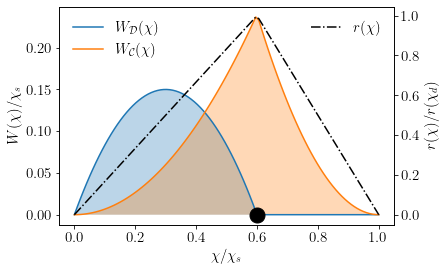

In [22]:
# Set parameters

chi_s = 1
chi_d = 0.6*chi_s
theta_E = 1


# Define the functions to be plotted

def W_D(chi):
    "Weight function for direct effect of foreground lenses."
    
    W = max(0, chi*(chi_d-chi)/chi_d)
    
    return W


def W_C(chi):
    "Weight function associated with lens-lens coupling."
    
    if chi <= chi_d:
        W = chi*(chi_s-chi)/chi_s - chi*(chi_d-chi)/chi_d
    else:
        W = chi*(chi_s-chi)/chi_s - (chi-chi_d)*(chi_s-chi)/(chi_s-chi_d)
    
    return W


def r(chi):
    "Comoving size of the critical beam."
    
    if chi <= chi_d:
        d = chi
    else:
        d = chi_d*(chi_s-chi)/(chi_s-chi_d)
    
    return theta_E*d


# Make the plots

chis = np.linspace(0, chi_s, 100)
W_Ds = np.array( [W_D(chi)/chi_s for chi in chis] )
W_Cs = np.array( [W_C(chi)/chi_s for chi in chis] )
rs = np.array( [r(chi)/chi_s for chi in chis] )

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

ax1.plot(chis, W_Ds, label=r'$W_{\mathcal{D}}(\chi)$')
ax1.fill(chis, W_Ds, alpha=0.3)
ax1.plot(chis, W_Cs, label=r'$W_{\mathcal{C}}(\chi)$')
ax1.fill(chis, W_Cs, alpha=0.3)
ax1.plot([chi_d],[0], 'ko', markersize=15)
ax1.set_xlabel(r'$\chi/\chi_s$')
ax1.set_ylabel(r'$W(\chi) /\chi_s$')
#ax1.plot([chi_d, chi_d], [0, 0.4], 'k--')
ax1.legend(loc='upper left', frameon=False)

ax2 = ax1.twinx()
ax2.plot(chis, rs/r(chi_d), 'k-.', label=r'$r(\chi)$')
ax2.set_ylabel(r'$r(\chi)/r(\chi_d)$') 
ax2.legend(loc='upper right', frameon=False);

#fig.tight_layout() 
#fig.savefig("figures/weight_functions.pdf",
#           format='pdf',
#            transparent=True,
#            bbox_inches='tight')

## Bessel weighting functions

We consider the Bessel pre-factors appearing in $q_n$ that filters the critical-mode power spectrum $P_{n_1 n_2}$. Namely, we are interested in the functions
\begin{align}
J_{\mathcal{D}}(x)
&\equiv
\frac{\delta_{n1}-2J'_n(x)}{x}
= \frac{\delta_{n1}}{x}+\frac{J_{n+1}(x)-J_{n-1}(x)}{x}
\\
J_{\mathcal{C}}(x)
&\equiv
\frac{2n^2 J_{n}(x)}{x^2}-\frac{2J_n'(x)}{x}
= J''_n(x)+J_n(x)
=\frac{J_{n-2}(x)+2J_{n}(x)+J_{n+2}(x)}{4} 
\end{align}

In [23]:
# Define the functions

def JD(n,x):
    """Bessel pre-factor of W_D in q_n."""
    
    if n==1:
        J = 1/x + (BesselJ(2,x)-BesselJ(0,x))/x
    
    else:
        J = (BesselJ(n+1,x)-BesselJ(n-1,x))/x
    
    return J
    

def JC(n,x):
    """Bessel pre-factor of W_C in q_n."""
    
    J = (BesselJ(n-2,x)+2*BesselJ(n,x)+BesselJ(n+2,x))/4
    
    return J

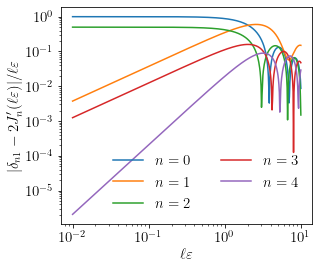

In [24]:
# Plot JD

x = np.logspace(-2,1,500)

plt.figure(figsize=(4.5,4))

for n in range(5):
    plt.loglog(x, abs(JD(n,x)), label=r'$n={}$'.format(n))

plt.xlabel(r'$\ell\varepsilon$')
plt.ylabel(r"$|\delta_{n1}-2J_n'(\ell\varepsilon)|/\ell\varepsilon$")
plt.legend(frameon=False, ncol=2)

#plt.savefig("figures/JD.pdf",
#            format='pdf',
#            transparent=True,
#            bbox_inches='tight')

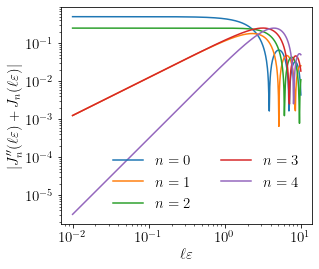

In [25]:
# Plot JC

x = np.logspace(-2,1,500)

plt.figure(figsize=(4.5,4))

for n in range(5):
    plt.loglog(x, abs(JC(n,x)), label=r'$n={}$'.format(n))

plt.xlabel(r'$\ell\varepsilon$')
plt.ylabel(r"$|J_n''(\ell\varepsilon)+J_n(\ell\varepsilon)|$")
plt.legend(frameon=False,ncol=2)

#plt.savefig("figures/JC.pdf",
#            format='pdf',
#            transparent=True,
#            bbox_inches='tight')